# Sporulation

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
from collections import defaultdict
import pickle

# third party imports
import pandas as pd
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from cobrame.util.helper_functions import *

import copy
from scipy import stats
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
ecoli_files = dirname(abspath(bacillusme.__file__))
pd.set_option('display.max_colwidth', None)
plt.rcParams['svg.fonttype'] = 'none'

/home/jt/work/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/work/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


Process enrichment at https://david.ncifcrf.gov/

In [2]:
# with open("./sporeme_solution_v4_proteomics_spoAQ.pickle", "rb") as outfile:
#     sporeme = pickle.load(outfile)

In [3]:
def parse_name(x):
    return x.split(".txt")[0].split("chart_")[1]

def parse_data(df):
    # df = df.rename(columns=lambda x:parse_name(x)[1])
    # df["(fold Enrichment)"] = df["(fold Enrichment)"].apply(lambda x:parse_float(x)).astype(float)
    df = df.loc[["UP_KW_BIOLOGICAL_PROCESS"]]
    df["Term"] = df["Term"].apply(lambda x:x.split("~")[1])
    df = df.reset_index().set_index("Term")
    df = df.drop("Genes",axis=1)
    return df

In [4]:
import os
dir = "./enrichment/results/"
dct = {}
for i in os.listdir(dir):
    if "chart" not in i:
        continue
    df = pd.read_csv(dir+i,sep='\t',index_col=0)
    name = parse_name(i)
    print(name)
    parsed = parse_data(df)
    dct[name] = parsed

FS_None_MC_True_VG_None
FS_False_MC_False_VG_False
FS_True_MC_False_VG_True
FS_True_MC_True_VG_True
FS_True_MC_None_VG_None
FS_False_MC_True_VG_False
FS_False_MC_False_VG_True
FS_True_MC_False_VG_False
FS_None_MC_None_VG_True
FS_False_MC_True_VG_True


## Save as Excel

In [5]:
def save_dict_of_dataframes_to_excel(dict_of_dataframes, excel_filename):
    """
    Save a dictionary of dataframes into an Excel worksheet, with each dataframe in a separate sheet.

    Parameters:
    - dict_of_dataframes (dict): A dictionary where keys are sheet names and values are dataframes.
    - excel_filename (str): The name of the Excel file to be created.

    Example:
    ```python
    dataframes_dict = {'Sheet1': df1, 'Sheet2': df2, 'Sheet3': df3}
    save_dict_of_dataframes_to_excel(dataframes_dict, 'output.xlsx')
    ```
    """
    with pd.ExcelWriter(excel_filename, engine='xlsxwriter') as writer:
        for sheet_name, dataframe in dict_of_dataframes.items():
            dataframe.to_excel(writer, sheet_name=sheet_name, index=True)


In [6]:
save_dict_of_dataframes_to_excel(dct,"./Supplementary Files/Supplementary File 6.xlsx")

## Plot

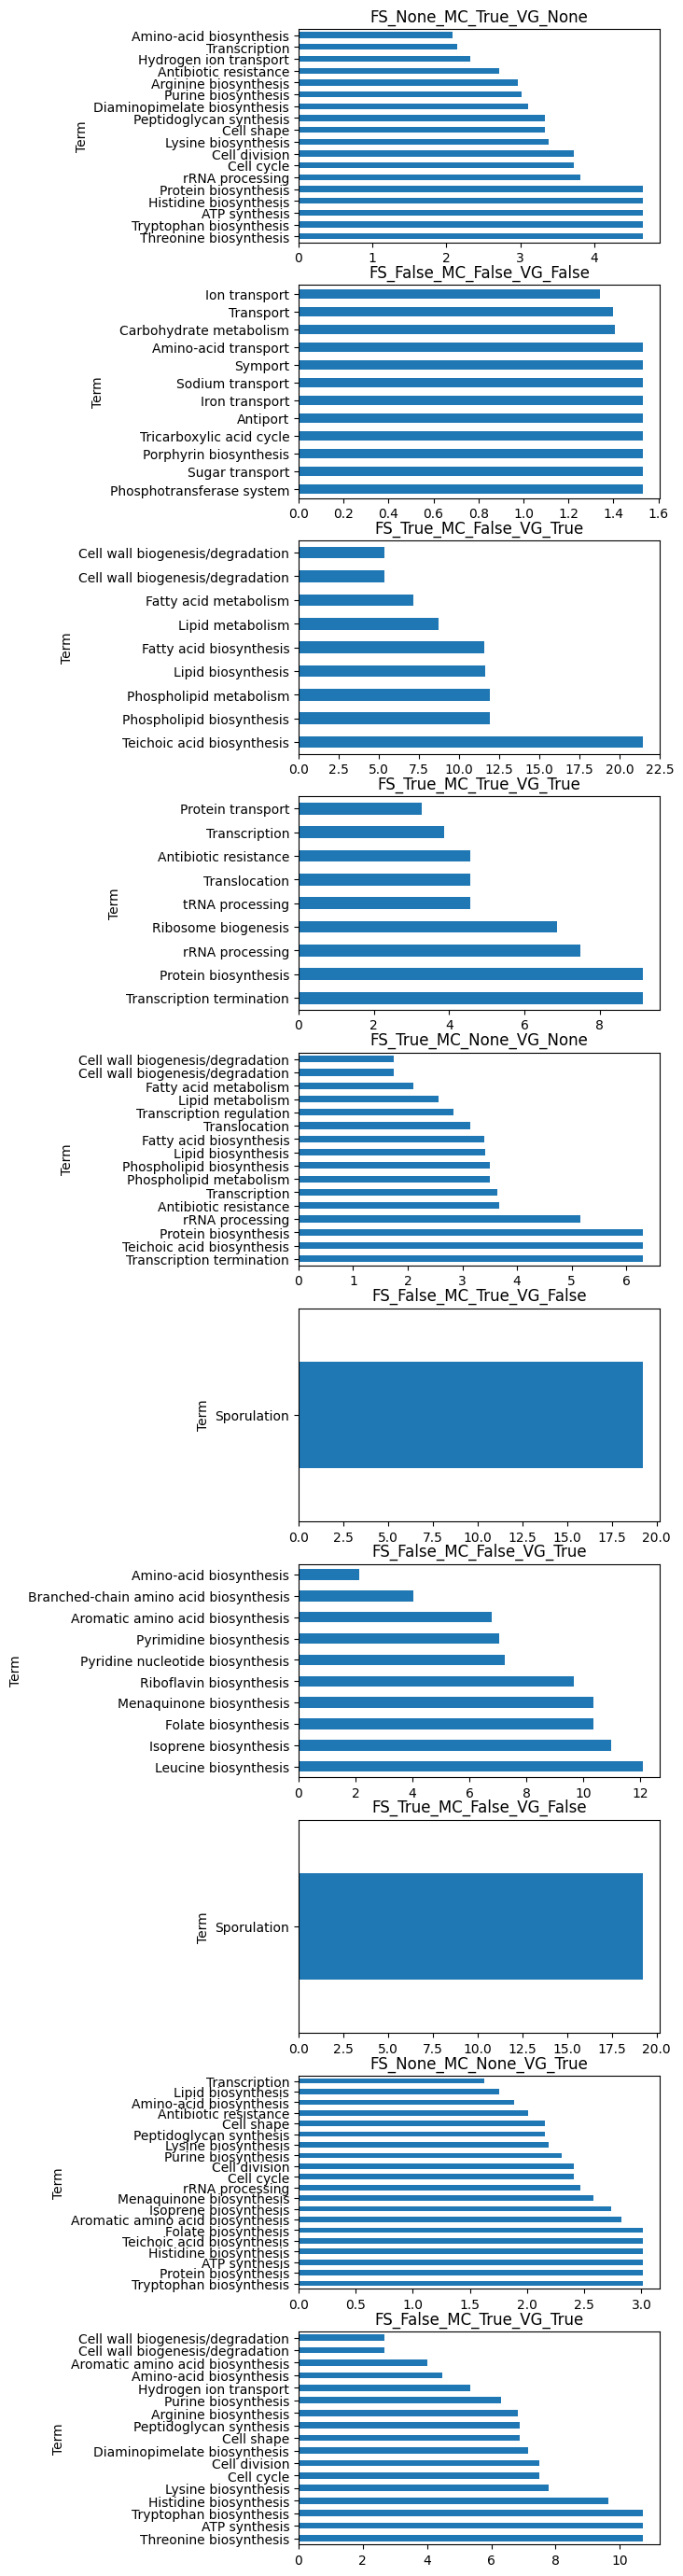

In [7]:
fig,ax = plt.subplots(len(dct),1,figsize=(5,35))
for idx,(cond,df) in enumerate(dct.items()):
    tmp = df["Fold Enrichment"]
    if tmp.empty:
        continue
    tmp.sort_values(ascending=False).head(20).plot.barh(ax=ax[idx])
    ax[idx].set_title(cond)
plt.savefig("./figures/3.1.2.2.enrichment.svg",format="SVG")

In [8]:
enrichment = {}
for cond,df in dct.items():
    enrichment[cond] = df["Fold Enrichment"].to_dict()
enrichment = pd.DataFrame.from_dict(enrichment)
enrichment = enrichment.drop("FS_False_MC_False_VG_False",axis=1)

In [9]:
lst = [
 'FS_None_MC_None_VG_True',
 'FS_None_MC_True_VG_None',
 'FS_True_MC_None_VG_None',
 'FS_True_MC_True_VG_True',
 'FS_True_MC_False_VG_True',
 'FS_False_MC_True_VG_True',
 'FS_True_MC_False_VG_False',
 'FS_False_MC_True_VG_False',
 'FS_False_MC_False_VG_True',
 # 'FS_False_MC_False_VG_False'
      ]

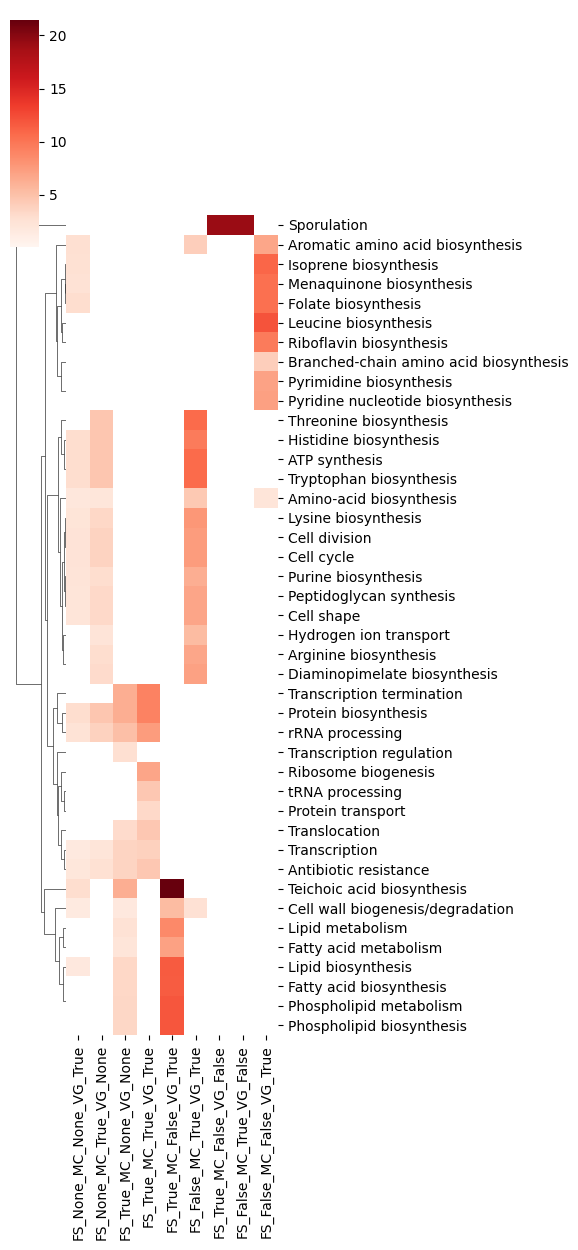

In [10]:
import seaborn as sns
cmap = plt.cm.get_cmap('Reds').copy()
cmap.set_under('white',alpha=0.05)
# vmin,vmax = (-4,4)
cmap_df = enrichment[(enrichment>0.1).any(axis=1)].fillna(0)[lst]

# cmap_df = df.fillna(0)
cmap = sns.clustermap(cmap_df,
               row_cluster=True,
               col_cluster=False,
               vmin=0.1,
               # vmax=vmax,
               # annot=True,
               # fmt=".1f",
               cmap=cmap,
               # annot_kws={'rotation': 90}
               figsize=(0.65*cmap_df.shape[1],(0.3)*cmap_df.shape[0]),
               # cbar=False,
              )
labels = [i.get_text() for i in cmap.ax_heatmap.xaxis.get_majorticklabels()]
# cmap.ax_heatmap.set_xticklabels(cmap.ax_heatmap.get_xticklabels(), rotation=90)
# _=plt.setp(cmap.ax_heatmap.get_xticklabels(), rotation=80)
plt.savefig("./figures/3.1.2.2.enrichment_clustermap.svg",format="SVG")

### Source data

In [12]:
cmap_df.to_csv("SourceData-4b.csv")